### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Copie este notebook y **modifique el nombre de archivo** agregando los apellidos de ambos miembros. Por ejemplo si los miembros del grupo son Pablo Huijse y Ana Nuñez el nombre sería: `info147_tarea2_huijse_nuñez.ipynb`
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña Puede agregar a su compañero en la pestaña *Settings/Manage access*
1. Sean leales y honestos, no copie los resultados de otros grupos, el único afectado es usted
1. Se evaluará el último commit antes de la fecha y hora de entrega

# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







## Introducción

En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos para comprobar o refutar los hallazgos de *D. Treisman*

## Datos

Para esta tarea se les provee de un conjunto de datos indexado por país con los siguientes atributos
- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [239]:
import pandas as pd
df = pd.read_csv('billonarios.csv', index_col='pais')
df.head(5)

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0


## Modelo

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> Note que el número de billonarios es una variable entera y no-negativa. Un modelo de regresión con verosimilitud Gaussiano no es apropiado

Se pide entonces que use una [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), definimos entonces la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 
- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

Considerando esto, se pide que

> Ajuste $\theta$ mediante la maximización de la verosimilitud

En primer lugar se pide que
1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es grande?
1. Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema
1. Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud

In [240]:
%matplotlib notebook

In [241]:
import numpy as np
import matplotlib as mpl
display(mpl.__version__)
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.special import factorial as fact
import pandas as pd
import scipy.optimize
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import train_test_split

'3.1.3'

#### 1.  Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro  𝜆 , ¿Qué ocurre cuando  𝜆  es grande?

La regresión de Poisson es una distribucion de probabilidad discreta. Y representa el número de ocurrencias, lambda corresponde a la tasa esperada de ocuurrencias. X es el vector de atributos del país (Población, PIB y años en GATT en nuestro caso).

La distribución de Poisson es un modelo apropiado si se cumplen las siguientes condiciones:

* k es el número de veces que un evento ocurre en un intervalo y puede tomar valores enteros mayores que -1.
* Los eventos ocurren de forma independiente.
* La tasa promedio en la que los eventos ocurren es independiente de cualquier ocurrencia. Es además constante.
* Dos eventos no pueden ocurrir al mismo instante.

**λ = 1** Evento que en promedio ocurre una vez por intervalo: k0 = k1 = 0.37 

A medida que lambda incrementa, la probabilidad de eventos en un intervalo se asemeja más y más a una distribución normal, donde el número de eventos k  con mayor probabilidad es igual a lambda (al valor entero más cercano).


In [242]:
def poisonxd(lmbd, Y):
    return (np.power(lmbd, Y)/fact(Y)) * np.exp(-lmbd)
    #return (lmbd**y/fact(y)) * np.exp(-lmbd)

<IPython.core.display.Javascript object>


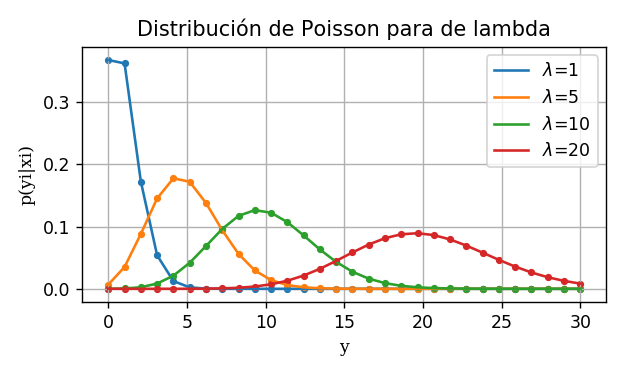

In [243]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True, facecolor='w')
# Tipos de linea: -, --, -., :, none
# Tipos de markers: .,o,x,d,s,1,2,3,4
y = np.linspace(start=0, stop=30, num=30)


#incorporar un intSlider para los valores de lambda?
for i in [1, 5, 10, 20]:
    values = [poisonxd(i, val) for val in y]
    plt.plot(y, values, label=f'$\lambda$={i}')
    plt.scatter(y,values,s=10)
    
ax.set_ylabel('p(yi|xi)', fontsize=10, fontname='serif', color="black")
ax.set_xlabel('y', fontsize=10, fontname='serif', color="black")
ax.set_title('Distribución de Poisson para de lambda')    
ax.grid()
ax.legend()
plt.show()

#### 2. Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema

Suponemos la independencia de las observaciones, la función de verosimilitid es igual al producto de sus funciones de de masa de probabilidad:

$$
\begin{align}
\mathcal{L}(\theta) &= \prod_{i=1}^N P(y_i|\theta) \nonumber \\
\mathcal{L}(\theta) &= \prod_{i=1}^N \frac{\lambda_i^{y_i}}{y_i!} e^\left ({-\lambda_i} \right) \nonumber \\
\end{align}
$$
Aplicando log se tiene
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log (\frac{\lambda_i^{y_i}}{y_i!})-\lambda_i \nonumber \\
\log \mathcal{L}(\theta) &=  \sum_{i=1}^N \log (\lambda_i^{y_i}) - \log (y_i!)-\lambda_i \nonumber \\
\log \mathcal{L}(\theta) &=  \sum_{i=1}^N {y_i} \log (\lambda_i) - \log (y_i!)-\lambda_i \nonumber \\
\end{align}
$$

Podemos omitir el término con el factorial que no aporta para escoger el mejor modelo.

#### 3. Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud
Separando para distintos valores de $j$ de $\theta_j$

Derivada con respecto a  $\theta_0$
$$
\begin{align}
\frac{\partial \log \mathcal{L}(\theta)}{\partial \theta_0}=\sum_{i=1}^N ({y_i} - \lambda_i)
\end{align}
$$

derivada con respecto a  $\theta_j$ con $\mathcal{j}$>0
$$
\begin{align}
\frac{\partial \log \mathcal{L}(\theta)}{\partial \theta_j}=\sum_{i=1}^N (({y_i} - \lambda_i) \sum_{i=1}^M {x_{ij}})
\end{align}
$$


## Implementación

#### 1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`


In [244]:
def getLambda(theta, X, Y):
    return np.exp(theta[0] + np.sum(theta[1:]*X, axis=1))


def neglogverosimilitud(theta, *args):
    X,Y = args
    suma = theta[0] + np.sum(theta[1:]*X, axis=1)
    if (suma.max() < 700):
        lmbd = np.exp(theta[0] + np.sum(theta[1:]*X, axis=1))
        return -np.sum((Y * np.log(lmbd + 1e-10) - lmbd), axis=0)
    else:
        #si lambda es muy grande ocurre overflow en el np.exp()
        #retornar un numero muy grande
        return np.exp(700) 
    
def grad_neglogverosimilitud(theta, *args):
    X, Y = args
    N = len(Y)
    f = modelo(theta, X, Y)  
    sumatoriaX = np.sum(X, axis=1)
    #para theta sub 0
    e = (Y - f)
    #para theta sub j, j > 0
    r = e * sumatoriaX
    #es lo mismo para j = 1, 2, 3
    GT0 = np.ones(shape=(N, theta.shape[0] - 1)) * r[:, np.newaxis]
    #unir sol para j == 0 y j > 0
    sol = np.concatenate((e[:, np.newaxis], GT0), axis=1)
    return -np.sum(sol, axis=0)   


#### 3. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$


In [245]:
def pseudCoCo(bestTheta, x, y):
    bestTheta0 = bestTheta[0]
    lmbd0 = np.ones(shape=(len(y), 1)) * abs(bestTheta0)
    neglogBestTheta0 = np.sum((y * np.log(lmbd0) - lmbd0))
    R2 = abs(neglogBestTheta0) - abs(neglogverosimilitud(best_theta, *(X, y)))
    return R2 / abs(neglogBestTheta0)

#### 2. Encuentre el vector de parámetros óptimo usando `scipy.optimize.minimize`, justifique su decisión para el  método y argumentos a usar

In [246]:
#cargar el dataframe y variables
df = pd.read_csv('billonarios.csv', index_col='pais')
y = df['nbillonarios'].values
x=df.drop(['nbillonarios'], axis=1)
X=x.values

Utilizamos `train_test_split` de `sklearn.model_selection` para separar de forma aleatoria las ocurrencias (y) y sus 
atributos (X) en secciones para el entrenamiento y testeo del modelo, con un 70% de la muestra destinada al entrenamiento.
En general, obtuvimos mejores resultados utilizanado un theta inicial con poca varianza y con pequeños valores negativos, a
pesar de que en un principio se trataba de un fix (que no funcionó del todo) para evitar overflows en la exponencial del neglog.
El método `BFGS` nos convergía en prácticamente todos los casos, y nos permitiría utilizar el gradiente cuando lo tuvieramos
operativo.


In [247]:
# Usaremos un callback para guardar el mejor modelo de validación
def eval_model(theta):
    global best_logl, best_theta
    logltrain = neglogverosimilitud(theta, *(X_train, y_train))
    logltest = neglogverosimilitud(theta, *(X_test, y_test))
    #print("Train: %0.4f, Test: %0.4f" %(logltrain, logltest))
    if logltest < best_logl: # Guardar el mejor modelo de test
        best_theta = theta    
        best_logl = logltest
        

def poissonModel(X, y):
    global best_logl, best_theta, X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)
    # Valor inicial de theta
    theta = 0.1*np.random.randn(1+X.shape[1]) - 0.1
    best_theta = np.zeros(1+X.shape[1])
    best_logl = np.inf
    res = scipy.optimize.minimize(fun=neglogverosimilitud, x0=theta, 
                                  method='BFGS', jac=False,
                                  args=(X_train, y_train),
                                  callback=eval_model, tol=1e-1)
    #print(res.message)
    pr = pseudCoCo(best_theta, X, y)
    if not (0.1 < pr < 1):
        return poissonModel(X, y)
    return best_theta, pr

In [248]:
bestTheta, R2 = poissonModel(X, y)

display(bestTheta)
display(R2)


array([-2.72830405e+01,  9.78631813e-01,  1.09546939e+00,  1.83320456e-02])

0.989617063992556

#### 4. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y para el pseudo coeficiente de correlación


In [249]:
def muestreo_reemplazo(x, y):
    M = len(x)
    idx = np.random.choice(M, size=M, replace=True)
    return x[idx], y[idx]

def boostrap_poisson(x, y, T=100):
    # Parámetros: theta0..3
    tSize = x.shape[1] + 1
    params = np.zeros(shape=(T, tSize))
    pseudoR = np.zeros(shape=(T, 1)) 
    for t in range(T):
        params[t], pseudoR[t] = poissonModel(*muestreo_reemplazo(x, y))
    return params, pseudoR

## Resultados

#### 1. Prediga la cantidad de billonarios de cada país usando su modelo. Muestre la cantidad de billonarios predicha y real para cada continente. ¿Qué puede comentar al respecto?




In [250]:
lmdPredict = getLambda(bestTheta, X, y)
predichos = lmdPredict.astype(int)
df['predicted'] = predichos

In [251]:
#https://github.com/dbouquin/IS_608/blob/master/NanosatDB_munging/Countries-Continents.csv
dfPais = pd.read_csv('Countries-Continents.csv', index_col="Country")
dfPais.rename_axis('pais', inplace=True)
dfPais.reset_index(inplace = True)
df.reset_index(inplace = True)
dfContinent = pd.merge(df, dfPais)
dfContinent.set_index("pais", inplace=True)

continentTotal = dfContinent.groupby(["Continent"]).sum()
continentTotal.sort_values('predicted', ascending=False, inplace=True)

In [252]:
continent=continentTotal.index.values[:15]
predicho=continentTotal['predicted'][:15].values
real=continentTotal['nbillonarios'][:15].values

<IPython.core.display.Javascript object>


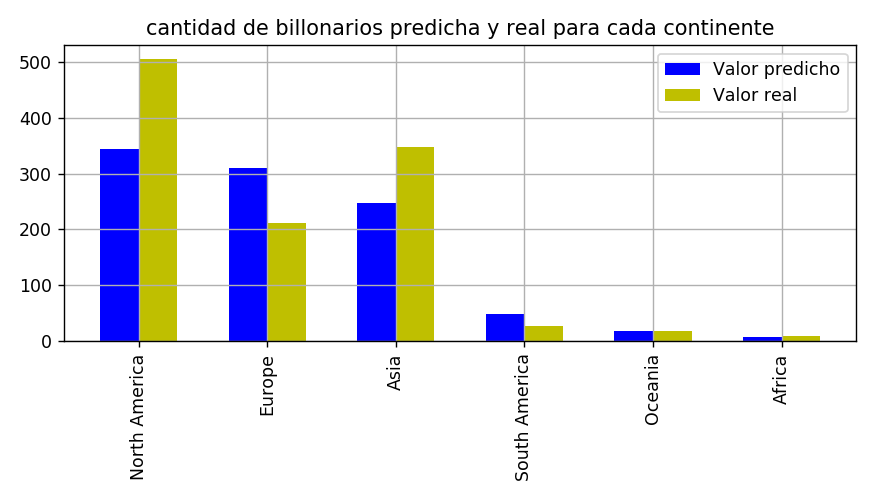

In [253]:
fig4, ax4 = plt.subplots(figsize=(7, 4), 
                       sharex=True, sharey=True, tight_layout=True)

x = np.array([i for i in range(6)])
ax4.bar(x-0.15, predicho, width=0.3, color='b', align='center', label="Valor predicho")
ax4.bar(x+0.15, real, width=0.3, color='y', align='center', label="Valor real")
plt.xticks(x, continent, rotation='vertical')
ax4.legend()
ax4.grid()
plt.title("cantidad de billonarios predicha y real para cada continente")
plt.show()

Lo primero que salta a la vista al graficar las predicciones y los valores reales por continente es la enorme diferencia 
que presenta **Norte América**, esto sin duda debido a la gran cantidad real de billonarios que posee **Estados Unidos**, con alrededor
de cinco veces el número de billonarios del país en segundo lugar, **Rusia**.
Otro punto interesante es que tanto **Europa como Asia** presentan diferencias en los valores predichos y reales cercanas al 30%,
con **Europa** con un valor predicho *mayor* que el real, y el caso contrario para **Asia** *(continente con el que etiquetamos a Rusia)*.
De los continentes restantes, que contribuyen con una fracción menor de billonarios, destaca el hecho de que **Sudamérica** posee menor cantidad de billonarios en comparación a la estimación de nuestro modelo.

#### 2. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?


In [254]:
boostrap_params, rvals = boostrap_poisson(X, y, T=1000)

<IPython.core.display.Javascript object>


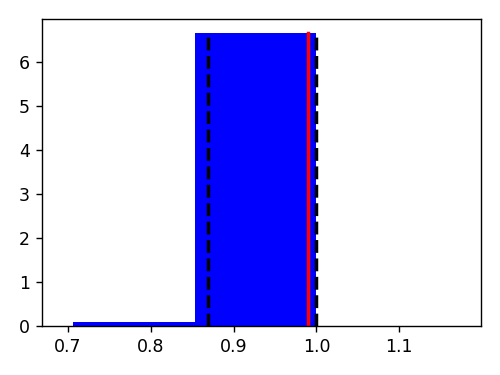

'Intervalo de confianza al 95% de r [0.86877243 0.99902365]'

In [255]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
hist_val, hist_lim, _ = ax.hist(rvals, bins=5, density=True, color='b')

ax.plot([R2]*2, [0, np.max(hist_val)], 'r-', lw=2)
IC = np.percentile(rvals, [2.5, 97.5])
ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)
ax.set_xlim(IC[0] - 0.2, IC[1] + 0.2)

display(f"Intervalo de confianza al 95% de r {IC}")

<IPython.core.display.Javascript object>


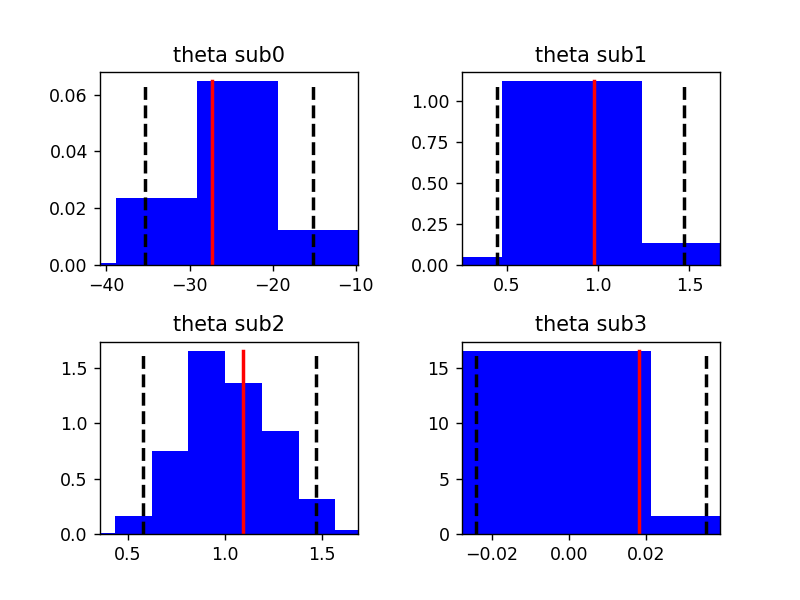

Intervalo de confianza al 95% de thetha0 [-35.32283043 -15.14362896]
Intervalo de confianza al 95% de thetha1 [0.45039443 1.47151424]
Intervalo de confianza al 95% de thetha2 [0.57768016 1.46736755]
Intervalo de confianza al 95% de thetha3 [-0.02409361  0.03561922]


In [256]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title(label="theta sub" + str(i))
    hist_val, hist_lim, _ = ax.hist(boostrap_params[:, i], bins=20, density=True, color='b') 
    ax.plot([bestTheta[i]]*2, [0, np.max(hist_val)], 'r-', lw=2)
    IC = np.percentile(boostrap_params[:, i], [2.5, 97.5])
    ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    ax.set_xlim(IC[0] - abs(bestTheta[i]/5), IC[1] + abs(bestTheta[i]/5))

    print(f"Intervalo de confianza al 95% de thetha{i} {IC}")
    

 #### ¿Cuáles parámetros tienen  𝜃  significativamente distinto de cero? 

Se observa que solo thetasub3 posee un valor muy cercano a cero, en otras palabras, podemos decir que si existe correlación positiva entre el pib y la población de un país, y el número de billonarios que este posee. theta3 en cambio fluctúa entre valores positivos y negativos pero muy cercanos al cero. 

#### ¿Cuál es el intervalo de confianza al 95% del  𝑅2 ? 

Intervalo de confianza al 95% de R2 [0.84517912 0.99891684]

#### ¿Qué puede decir sobre su modelo?

Por lo cercando a 1 del R2 obtenido, podemos decir que el modelo se ajusta de buena forma a la variable real.

#### 3. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles paises tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?

<IPython.core.display.Javascript object>


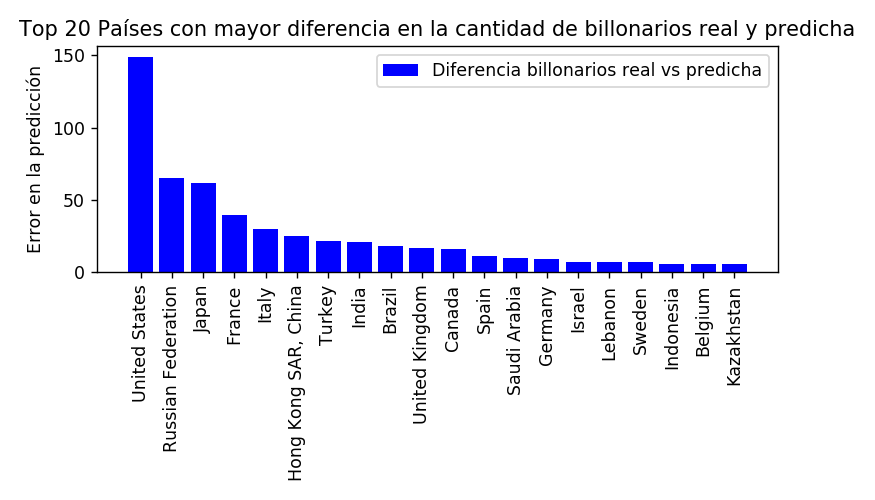

In [257]:
#display(df.head(10))
df['error'] = (df['nbillonarios'] - df['predicted']).abs()
df.sort_values('error', ascending=False, inplace=True)
fig5, ax5 = plt.subplots(figsize=(7, 4), tight_layout=True)
#ax5.grid()
x = np.array([i for i in range(20)])
ax5.bar(x, df['error'][:20], color='b', align='center', label="Diferencia billonarios real vs predicha")
plt.xticks(x, df['pais'][:20], rotation='vertical')
ax5.legend()
ax5.set_ylabel('Error en la predicción')

plt.title("Top 20 Países con mayor diferencia en la cantidad de billonarios real y predicha")
plt.show()

<IPython.core.display.Javascript object>


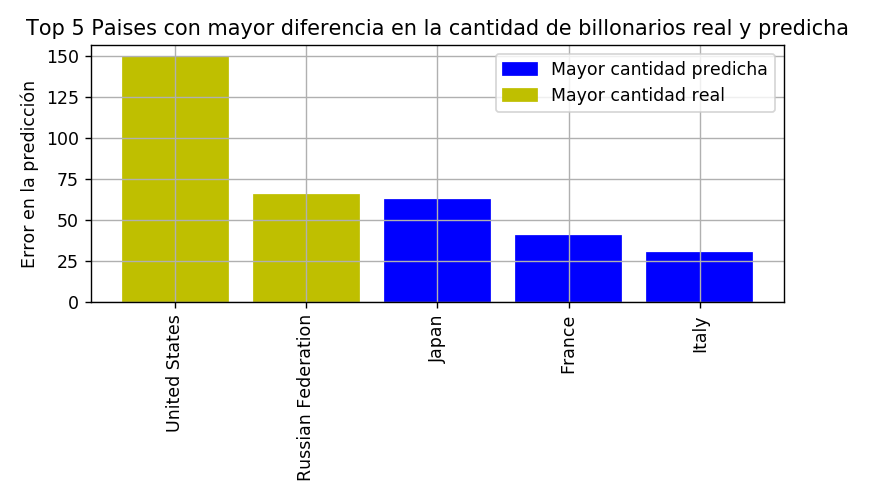

In [260]:
fig6, ax6 = plt.subplots(figsize=(7, 4), tight_layout=True)

x = np.array([i for i in range(5)])
ax6.bar(x, df['error'][:5], color='b', align='center', label="Diferencia billonarios real vs predicha")
plt.xticks(x, df['pais'][:5], rotation='vertical')
ax6.legend()
plt.title("Top 5 Paises con mayor diferencia en la cantidad de billonarios real y predicha")
ax6.grid()
barlist = plt.bar(x, df['error'][:5])

for i in range(5):
    if(df.iloc[i]['nbillonarios'] > df.iloc[3]['predicted']):
        barlist[i].set_color('y')
    else:
        barlist[i].set_color('b')

legend_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='Mayor cantidad predicha'),
                  Patch(facecolor='y', edgecolor='y',
                         label='Mayor cantidad real')]
ax6.legend(handles=legend_elements, loc='upper right')
ax6.set_ylabel('Error en la predicción')

plt.show()

In [259]:
df.head(5)

,pais,nbillonarios,logpibpc,logpob,gatt,predicted,error
0,United States,469,10.786021,19.532846,60,320,149
72,Russian Federation,87,9.366808,18.771030,37,22,65
163,Japan,24,10.544774,18.665226,53,86,62
43,France,14,10.722429,17.980175,60,54,40
56,Italy,13,10.612207,17.890106,58,43,30


#### ¿Cuáles son los 5 países con mayor error en la predicción? 
Los 5 países con mayor error son Estados Unidos, China, Rusia, Japón y Francia.

#### ¿Cuáles paises tienen un exceso de billonarios? 
Del top 5 con mayor error, Estados Unidos y Rusia tienen un exceso de billonarios.

#### ¿Cúales paises tienen menos billonarios de lo esperado?
Tanto Italia como Japón y Francia, países donde la predicción mayor al valor real se puede asociar a su alto PIB.

#### ¿Qué puede decir sobre Rusia?

Según nuestros análisis Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos por lo que comprobamos lo concluido por *Daniel Treisman* en su artículo (Russia Billionaries). Los parámetros sugerían un número similar a la cantidad real de billonarios que posee Japón, sin embargo, posee un número que lo posiciona como el segundo país con más billonarios (a la fecha del estudio) del mundo.

## Conclusiones

#### Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 

Si bien los indicadores económicos son una buena forma de predecir la cantidad de billonarios que tiene un país, esto no necesariamente se ajusta a la realidad ya que como vimos existen paises como Estados Unidos y Rusia en que tienen más billonarios de los que se predicen, de la misma forma pasa con los paises que tienen menos billonarios de lo esperado. Esta diferencia puede ocurrir por otros factores distintos a los que se usaron para predecir, como aspectos legales, culturales, geográficos, entre otros.

Uno de los desafíos al desarrollar la Tarea fue la dificultad en la interpretación de los datos obtenidos y cómo aplicarlos en las partes siguientes del trabajo, un ejemplo de esto ocurrió con qué significaban los valores encontrados en nuestro modelo y cómo utilizarlos. Al principio no teníamos claro cómo utilizar los valores de theta para realizar la predicción, lo que dificultaba la tarea de comprobar si nuestras expresiones y funciones de verosimilitud iban bien encaminadas. Superamos estas dificultades estudiando el tema y revisando ejemplos similares, logrando finalmente obtener resultados que nos permitieron comprobar los hallazgos de Daniel Treisman, y, de paso, adquirir un mayor entendimiento de los conceptos y aplicaciones de la estadística. 